In [1]:
import jax.numpy as jnp 
from jax import vmap, jit
import matplotlib.pyplot as plt 

try:
    from lqrax import iLQR
except:
    %pip install lqrax
    from lqrax import iLQR

In [2]:
class RocketLandingILQR(iLQR):
    def __init__(self, dt, x_dim, u_dim, Q, R):
        super().__init__(dt, x_dim, u_dim, Q, R)
    
    def wrap(self, angle):
        return (angle + jnp.pi) % (2 * jnp.pi) - jnp.pi
    
    def wrap_state(self, xt):
        return jnp.array([xt[0], self.wrap(xt[1]), xt[2], xt[3]])

    def dyn(self, xt, ut):
        x, y, vx, vy, theta, omega = xt
        T, tau = ut
        m = 1.0
        I = 5.0
        g = 9.81
        dx = vx
        dy = vy
        dvx = (T / m) * jnp.sin(theta)
        dvy = (T / m) * jnp.cos(theta) - g
        dtheta = omega
        domega = tau / I
        return jnp.array([dx, dy, dvx, dvy, dtheta, domega])
    
    def loss(self, xt, ut):
        target = jnp.zeros(6)
        state_error = xt - target
        return jnp.sum(state_error**2) + 0.01 * jnp.sum(ut**2)

iter[ 0] - loss: 2667.7830, step_size: 0.0329
iter[10] - loss: 78.2732, step_size: 0.0149
iter[20] - loss: 52.9829, step_size: 0.0530
iter[30] - loss: 51.9129, step_size: 0.0149
iter[40] - loss: 51.2887, step_size: 0.0149
iter[50] - loss: 50.2164, step_size: 0.0108
iter[60] - loss: 47.0019, step_size: 0.0174
iter[70] - loss: 46.4277, step_size: 0.0174
iter[80] - loss: 46.4246, step_size: 0.0621
iter[90] - loss: 46.4246, step_size: 0.0010


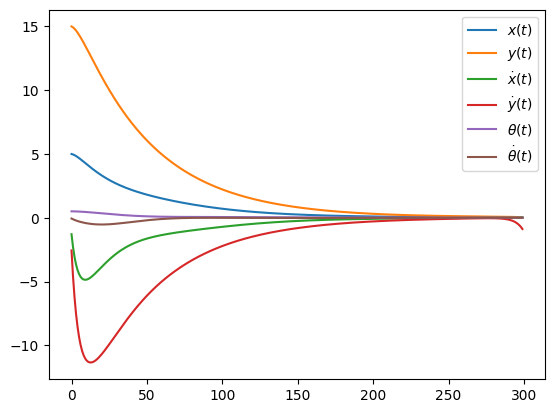

In [3]:
Q = jnp.diag(jnp.array([100.0, 100.0, 10.0, 10.0, 1000.0, 100.0])) * 0.001
R = jnp.diag(jnp.array([1.0, 1.0])) * 0.001
rocket_ilqr = RocketLandingILQR(dt=0.02, x_dim=6, u_dim=2, Q=Q, R=R)


@jit 
def loss_func(x_traj, u_traj):
    return vmap(rocket_ilqr.loss, in_axes=(0,0))(x_traj, u_traj).mean()

@jit 
def line_search(x0, u_traj, v_traj, step_sizes):
    u_traj_batch = u_traj[None, :, :] + step_sizes[:, None, None] * v_traj[None, :, :]
    x_traj_batch = vmap(rocket_ilqr.dyn_scan, in_axes=(None,0))(x0, u_traj_batch)
    costs = vmap(loss_func, in_axes=(0,0))(x_traj_batch, u_traj_batch)
    return step_sizes[jnp.argmin(costs)]


x0 = jnp.array([5.0, 15.0, 0.0, 0.0, 0.5, 0.0])
tsteps = 300
tlist = jnp.arange(tsteps)
u_traj = jnp.zeros((tsteps, 2))
x_traj = rocket_ilqr.dyn_scan(x0, u_traj)

num_iters = 100
step_sizes = jnp.power(10.0, jnp.linspace(-3.0, -1.0, 30))
for iter in range(num_iters):
    A_traj, B_traj = rocket_ilqr.linearize_dyn(x0, u_traj)
    a_traj, b_traj = rocket_ilqr.linearize_loss(x0, u_traj)
    v_traj = rocket_ilqr.solve(A_traj, B_traj, a_traj, b_traj)
    step_size = line_search(x0, u_traj, v_traj, step_sizes)
    u_traj += step_size * v_traj
    if iter % 10 == 0:
        x_traj = rocket_ilqr.dyn_scan(x0, u_traj)
        loss = loss_func(x_traj, u_traj)
        print(f'iter[{iter:2d}] - loss: {loss:.4f}, step_size: {step_size:.4f}')

opt_x_traj = rocket_ilqr.dyn_scan(x0, u_traj)
plt.plot(opt_x_traj[:,0], label=r'$x(t)$')
plt.plot(opt_x_traj[:,1], label=r'$y(t)$')
plt.plot(opt_x_traj[:,2], label=r'$\dot{x}(t)$')
plt.plot(opt_x_traj[:,3], label=r'$\dot{y}(t)$')
plt.plot(opt_x_traj[:,4], label=r'$\theta(t)$')
plt.plot(opt_x_traj[:,5], label=r'$\dot{\theta}(t)$')
plt.legend()
plt.show()
plt.close()

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

def animate_trajectory(states, controls):
    L = 2.0
    foot_offset = 0.5
    fire_scale = 0.05
    tau_scale = 0.03
    margin = 2.0
    xmin, xmax = states[:,0].min()-margin, states[:,0].max()+margin
    ymin, ymax = states[:,1].min()-margin*0.5, states[:,1].max()+margin*1.5
    yscale = (ymax - ymin) / (xmax - xmin)
    fig, ax = plt.subplots(figsize=(4.0, 4.0*yscale), dpi=100, tight_layout=True)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_aspect('equal')
    ax.plot(0.0, 0.0, marker='x', markersize=15, color='b')
    rocket_line, = ax.plot([], [], 'k-', lw=2)
    left_foot_line, = ax.plot([], [], 'k-', lw=2)
    right_foot_line, = ax.plot([], [], 'k-', lw=2)
    fire_line, = ax.plot([], [], color='orange', lw=3)
    tau_arrow, = ax.plot([], [], color='red', lw=3)
    def init():
        rocket_line.set_data([], [])
        left_foot_line.set_data([], [])
        right_foot_line.set_data([], [])
        fire_line.set_data([], [])
        tau_arrow.set_data([], [])
        return rocket_line, left_foot_line, right_foot_line, fire_line, tau_arrow
    def update(i):
        state = states[i]
        control = controls[i]
        x, y, vx, vy, theta, omega = state
        T, tau = control
        body_dir = np.array([np.sin(theta), np.cos(theta)])
        perp = np.array([np.cos(theta), -np.sin(theta)])
        bottom = np.array([x, y]) #- (L/2)*body_dir
        top = np.array([x, y]) + L * body_dir
        rocket_line.set_data([bottom[0], top[0]], [bottom[1], top[1]])
        left_foot = bottom + foot_offset*perp
        right_foot = bottom - foot_offset*perp
        left_foot_line.set_data([bottom[0], left_foot[0]], [bottom[1], left_foot[1]])
        right_foot_line.set_data([bottom[0], right_foot[0]], [bottom[1], right_foot[1]])
        if T > 1e-3:
            fire_len = fire_scale * T
            fire_end = bottom - fire_len*body_dir
            fire_line.set_data([bottom[0], fire_end[0]], [bottom[1], fire_end[1]])
        else:
            fire_line.set_data([], [])
        if abs(tau) > 1e-3:
            arrow_dir = perp if tau >= 0 else -perp
            arrow_len = tau_scale * abs(tau)
            body_middle = np.array([x, y]) + (L/2)*body_dir
            arrow_end = body_middle - arrow_dir * arrow_len
            tau_arrow.set_data([body_middle[0], arrow_end[0]], [body_middle[1], arrow_end[1]])
        else:
            tau_arrow.set_data([], [])
        return rocket_line, left_foot_line, right_foot_line, fire_line, tau_arrow
    ani = animation.FuncAnimation(fig, update, frames=len(states), init_func=init, interval=20, blit=True)
    video = HTML(ani.to_html5_video())
    plt.close(fig)
    return video


animate_trajectory(opt_x_traj, u_traj)